In [1]:
import time
import math
import os
import torch.nn as nn

import torch.onnx
import torch
from torch.autograd import Variable
import torch.optim as optim

import model as rnn_model
import data

In [2]:
args_seed = 1234
args_temperature = 1.
args_data = '../data/wikitext-2'
args_model = 'LSTM'
args_emsize = 800
args_nhid = 800
args_nlayers = 2
args_clip = 0.25
args_epochs = 40
args_batch_size = 20
args_bptt = 35
args_dropout = 0.2
args_log_interval = 200
args_save = 'model_800.pt'
args_save_state = 'model_state_800.pt'
args_tied = True

In [15]:
torch.manual_seed(args_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'using device: {device}')

using device: cuda


In [16]:
###############################################################################
# Load data
###############################################################################

corpus = data.Corpus(args_data)

In [17]:
# Starting from sequential data, batchify arranges the dataset into columns.
# For instance, with the alphabet as the sequence and batch size 4, we'd get
# ┌ a g m s ┐
# │ b h n t │
# │ c i o u │
# │ d j p v │
# │ e k q w │
# └ f l r x ┘.
# These columns are treated as independent by the model, which means that the
# dependence of e. g. 'g' on 'f' can not be learned, but allows more efficient
# batch processing.

def batchify(data, bsz):
    # Work out how cleanly we can divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

eval_batch_size = 10
train_data = batchify(corpus.train, args_batch_size)
val_data = batchify(corpus.valid, eval_batch_size)
test_data = batchify(corpus.test, eval_batch_size)

In [18]:
###############################################################################
# Build the model
###############################################################################

ntokens = len(corpus.dictionary)
model = rnn_model.RNNModel(args_model, ntokens, args_emsize, args_nhid, args_nlayers, args_dropout, args_tied).to(device)

criterion = nn.CrossEntropyLoss()

In [21]:
###############################################################################
# Use Adam optimizer
###############################################################################

# create your optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [22]:
###############################################################################
# Training code
###############################################################################

def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

In [23]:
# get_batch subdivides the source data into chunks of length args.bptt.
# If source is equal to the example output of the batchify function, with
# a bptt-limit of 2, we'd get the following two Variables for i = 0:
# ┌ a g m s ┐ ┌ b h n t ┐
# └ b h n t ┘ └ c i o u ┘
# Note that despite the name of the function, the subdivison of data is not
# done along the batch dimension (i.e. dimension 1), since that was handled
# by the batchify function. The chunks are along dimension 0, corresponding
# to the seq_len dimension in the LSTM.

def get_batch(source, i):
    seq_len = min(args_bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target


def evaluate(data_source):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    total_loss = 0.
    ntokens = len(corpus.dictionary)
    hidden = model.init_hidden(eval_batch_size)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, args_bptt):
            data, targets = get_batch(data_source, i)
            output, hidden = model(data, hidden)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
            hidden = repackage_hidden(hidden)
    return total_loss / len(data_source)


def train():
    # Turn on training mode which enables dropout.
    model.train()
    total_loss = 0.
    start_time = time.time()
    ntokens = len(corpus.dictionary)
    hidden = model.init_hidden(args_batch_size)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, args_bptt)):
        data, targets = get_batch(train_data, i)
        # Starting each batch, we detach the hidden state from how it was previously produced.
        # If we didn't, the model would try backpropagating all the way to start of the dataset.
        hidden = repackage_hidden(hidden)
        optimizer.zero_grad()   # zero the gradient buffers
        output, hidden = model(data, hidden)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        optimizer.step()    # Does the update
        total_loss += loss.item()

        if batch % args_log_interval == 0 and batch > 0:
            cur_loss = total_loss / args_log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | ms/batch {:5.2f} | '
                    'loss {:5.2f} | ppl {:8.2f}'.format(
                epoch, batch, len(train_data) // args_bptt, 
                elapsed * 1000 / args_log_interval, cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()


In [24]:
# Loop over epochs.
best_val_loss = None

# At any point you can hit Ctrl + C to break out of training early.
try:
    for epoch in range(1, args_epochs+1):
        epoch_start_time = time.time()
        train()
        val_loss = evaluate(val_data)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
                'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                           val_loss, math.exp(val_loss)))
        print('-' * 89)
        # Save the model if the validation loss is the best we've seen so far.
        if not best_val_loss or val_loss < best_val_loss:
            with open(args_save, 'wb') as f:
                torch.save(model, f)
            ## Save State Dictionary
            with open(args_save_state, 'wb') as f:
                torch.save(model.state_dict(), f)
            best_val_loss = val_loss

except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')

| epoch   1 |   200/ 2983 batches | ms/batch 95.98 | loss  6.16 | ppl   475.62
| epoch   1 |   400/ 2983 batches | ms/batch 92.70 | loss  6.26 | ppl   525.64
| epoch   1 |   600/ 2983 batches | ms/batch 94.51 | loss  6.22 | ppl   504.77
| epoch   1 |   800/ 2983 batches | ms/batch 93.02 | loss  6.28 | ppl   534.60
| epoch   1 |  1000/ 2983 batches | ms/batch 95.99 | loss  6.24 | ppl   515.13
| epoch   1 |  1200/ 2983 batches | ms/batch 94.41 | loss  6.28 | ppl   533.54
| epoch   1 |  1400/ 2983 batches | ms/batch 92.85 | loss  6.29 | ppl   539.75
| epoch   1 |  1600/ 2983 batches | ms/batch 92.49 | loss  6.32 | ppl   556.64
| epoch   1 |  1800/ 2983 batches | ms/batch 91.34 | loss  6.24 | ppl   513.74
| epoch   1 |  2000/ 2983 batches | ms/batch 91.39 | loss  6.28 | ppl   531.76
| epoch   1 |  2200/ 2983 batches | ms/batch 91.60 | loss  6.20 | ppl   490.97
| epoch   1 |  2400/ 2983 batches | ms/batch 91.38 | loss  6.24 | ppl   515.41
| epoch   1 |  2600/ 2983 batches | ms/batch 91.40 |

| epoch   7 |   400/ 2983 batches | ms/batch 91.40 | loss  6.01 | ppl   408.29
| epoch   7 |   600/ 2983 batches | ms/batch 91.33 | loss  5.94 | ppl   381.45
| epoch   7 |   800/ 2983 batches | ms/batch 91.26 | loss  5.99 | ppl   400.87
| epoch   7 |  1000/ 2983 batches | ms/batch 91.34 | loss  5.99 | ppl   397.68
| epoch   7 |  1200/ 2983 batches | ms/batch 91.28 | loss  6.02 | ppl   412.95
| epoch   7 |  1400/ 2983 batches | ms/batch 91.30 | loss  6.02 | ppl   410.08
| epoch   7 |  1600/ 2983 batches | ms/batch 91.34 | loss  6.04 | ppl   421.12
| epoch   7 |  1800/ 2983 batches | ms/batch 91.25 | loss  5.99 | ppl   397.89
| epoch   7 |  2000/ 2983 batches | ms/batch 91.30 | loss  6.04 | ppl   421.63
| epoch   7 |  2200/ 2983 batches | ms/batch 91.31 | loss  5.96 | ppl   387.98
| epoch   7 |  2400/ 2983 batches | ms/batch 91.32 | loss  6.00 | ppl   402.53
| epoch   7 |  2600/ 2983 batches | ms/batch 91.26 | loss  6.01 | ppl   409.45
| epoch   7 |  2800/ 2983 batches | ms/batch 91.26 |

| epoch  13 |   600/ 2983 batches | ms/batch 91.33 | loss  5.93 | ppl   377.56
| epoch  13 |   800/ 2983 batches | ms/batch 91.31 | loss  5.98 | ppl   396.34
| epoch  13 |  1000/ 2983 batches | ms/batch 91.32 | loss  5.97 | ppl   389.59
| epoch  13 |  1200/ 2983 batches | ms/batch 91.35 | loss  6.00 | ppl   404.59
| epoch  13 |  1400/ 2983 batches | ms/batch 91.30 | loss  6.00 | ppl   403.18
| epoch  13 |  1600/ 2983 batches | ms/batch 91.38 | loss  6.03 | ppl   415.60
| epoch  13 |  1800/ 2983 batches | ms/batch 91.38 | loss  5.97 | ppl   391.43
| epoch  13 |  2000/ 2983 batches | ms/batch 91.34 | loss  6.03 | ppl   414.43
| epoch  13 |  2200/ 2983 batches | ms/batch 91.42 | loss  5.94 | ppl   380.96
| epoch  13 |  2400/ 2983 batches | ms/batch 91.41 | loss  5.98 | ppl   396.26
| epoch  13 |  2600/ 2983 batches | ms/batch 91.32 | loss  6.00 | ppl   402.00
| epoch  13 |  2800/ 2983 batches | ms/batch 91.39 | loss  5.95 | ppl   382.95
----------------------------------------------------

| epoch  19 |   800/ 2983 batches | ms/batch 91.19 | loss  5.97 | ppl   391.43
| epoch  19 |  1000/ 2983 batches | ms/batch 91.24 | loss  5.96 | ppl   386.48
| epoch  19 |  1200/ 2983 batches | ms/batch 91.26 | loss  6.00 | ppl   401.49
| epoch  19 |  1400/ 2983 batches | ms/batch 91.19 | loss  5.99 | ppl   400.10
| epoch  19 |  1600/ 2983 batches | ms/batch 91.26 | loss  6.02 | ppl   410.56
| epoch  19 |  1800/ 2983 batches | ms/batch 91.31 | loss  5.96 | ppl   388.60
| epoch  19 |  2000/ 2983 batches | ms/batch 91.17 | loss  6.02 | ppl   411.17
| epoch  19 |  2200/ 2983 batches | ms/batch 91.29 | loss  5.94 | ppl   378.58
| epoch  19 |  2400/ 2983 batches | ms/batch 91.16 | loss  5.97 | ppl   391.18
| epoch  19 |  2600/ 2983 batches | ms/batch 91.24 | loss  5.98 | ppl   397.33
| epoch  19 |  2800/ 2983 batches | ms/batch 91.26 | loss  5.94 | ppl   379.98
-----------------------------------------------------------------------------------------
| end of epoch  19 | time: 283.80s | vali

| epoch  25 |  1000/ 2983 batches | ms/batch 91.31 | loss  5.95 | ppl   382.38
| epoch  25 |  1200/ 2983 batches | ms/batch 91.28 | loss  5.98 | ppl   397.40
| epoch  25 |  1400/ 2983 batches | ms/batch 91.28 | loss  5.98 | ppl   395.29
| epoch  25 |  1600/ 2983 batches | ms/batch 91.27 | loss  6.01 | ppl   407.91
| epoch  25 |  1800/ 2983 batches | ms/batch 91.28 | loss  5.96 | ppl   385.95
| epoch  25 |  2000/ 2983 batches | ms/batch 91.30 | loss  6.01 | ppl   407.20
| epoch  25 |  2200/ 2983 batches | ms/batch 91.28 | loss  5.93 | ppl   375.98
| epoch  25 |  2400/ 2983 batches | ms/batch 91.25 | loss  5.96 | ppl   387.54
| epoch  25 |  2600/ 2983 batches | ms/batch 91.22 | loss  5.98 | ppl   394.54
| epoch  25 |  2800/ 2983 batches | ms/batch 91.27 | loss  5.93 | ppl   376.65
-----------------------------------------------------------------------------------------
| end of epoch  25 | time: 283.91s | valid loss  5.89 | valid ppl   362.98
---------------------------------------------

| epoch  31 |  1200/ 2983 batches | ms/batch 91.26 | loss  5.98 | ppl   395.80
| epoch  31 |  1400/ 2983 batches | ms/batch 91.26 | loss  5.97 | ppl   392.24
| epoch  31 |  1600/ 2983 batches | ms/batch 91.21 | loss  6.00 | ppl   404.41
| epoch  31 |  1800/ 2983 batches | ms/batch 91.25 | loss  5.95 | ppl   383.58
| epoch  31 |  2000/ 2983 batches | ms/batch 91.21 | loss  6.00 | ppl   405.45
| epoch  31 |  2200/ 2983 batches | ms/batch 91.22 | loss  5.92 | ppl   373.42
| epoch  31 |  2400/ 2983 batches | ms/batch 91.25 | loss  5.95 | ppl   385.48
| epoch  31 |  2600/ 2983 batches | ms/batch 91.25 | loss  5.97 | ppl   392.07
| epoch  31 |  2800/ 2983 batches | ms/batch 91.17 | loss  5.93 | ppl   374.69
-----------------------------------------------------------------------------------------
| end of epoch  31 | time: 283.79s | valid loss  5.89 | valid ppl   362.90
-----------------------------------------------------------------------------------------
| epoch  32 |   200/ 2983 batches 

| epoch  37 |  1400/ 2983 batches | ms/batch 91.37 | loss  5.97 | ppl   391.68
| epoch  37 |  1600/ 2983 batches | ms/batch 91.38 | loss  6.00 | ppl   403.00
| epoch  37 |  1800/ 2983 batches | ms/batch 91.21 | loss  5.94 | ppl   381.43
| epoch  37 |  2000/ 2983 batches | ms/batch 91.21 | loss  6.00 | ppl   402.22
| epoch  37 |  2200/ 2983 batches | ms/batch 91.27 | loss  5.91 | ppl   368.52
| epoch  37 |  2400/ 2983 batches | ms/batch 91.30 | loss  5.95 | ppl   383.05
| epoch  37 |  2600/ 2983 batches | ms/batch 91.32 | loss  5.97 | ppl   391.11
| epoch  37 |  2800/ 2983 batches | ms/batch 91.28 | loss  5.93 | ppl   374.40
-----------------------------------------------------------------------------------------
| end of epoch  37 | time: 283.97s | valid loss  5.90 | valid ppl   363.98
-----------------------------------------------------------------------------------------
| epoch  38 |   200/ 2983 batches | ms/batch 91.73 | loss  5.99 | ppl   397.96
| epoch  38 |   400/ 2983 batches 

In [25]:
# Load the best saved model.
with open(args_save, 'rb') as f:
    model = torch.load(f)
    # after load the rnn params are not a continuous chunk of memory
    # this makes them a continuous chunk, and will speed up forward pass
    model.rnn.flatten_parameters()

# Run on test data.
test_loss = evaluate(test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)


| End of training | test loss  5.79 | test ppl   327.77


# Try to generate with this model now

In [3]:
args_data = '../data/wikitext-2'
args_checkpoint = args_save #'./model.pt'
args_state_dict = args_save_state # './model_state.pt'
args_outf = 'generated.txt'
args_words = 1000
args_seed = 1234
args_temperature = 1.0
args_log_interval = 100

In [4]:
# Set the random seed manually for reproducibility.
torch.manual_seed(args_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [5]:
if args_temperature < 1e-3:
    print("args_temperature has to be greater or equal 1e-3")


In [6]:
corpus = data.Corpus(args_data)
ntokens = len(corpus.dictionary)

In [27]:
with open(args_checkpoint, 'rb') as f:
    model = torch.load(f).to(device)
# model = rnn_model.RNNModel(args_model, ntokens, args_emsize, args_nhid, args_nlayers, args_dropout, args_tied).to(device)
# with open(args_state_dict, 'rb') as f:
#     state_dict = torch.load(f)
#     model.load_state_dict(state_dict)

In [28]:
hidden = model.init_hidden(1)
input = torch.randint(ntokens, (1, 1), dtype=torch.long).to(device)

In [29]:
model.eval()

RNNModel(
  (drop): Dropout(p=0.2)
  (encoder): Embedding(33278, 800)
  (rnn): LSTM(800, 800, num_layers=2, dropout=0.2)
  (decoder): Linear(in_features=800, out_features=33278, bias=True)
)

In [30]:
with open(args_outf, 'w') as outf:
    with torch.no_grad():  # no tracking history
        for i in range(args_words):
            output, hidden = model(input, hidden)
            word_weights = output.squeeze().div(args_temperature).exp().cpu()
            word_idx = torch.multinomial(word_weights, 1)[0]
            input.fill_(word_idx)
            word = corpus.dictionary.idx2word[word_idx]

            outf.write(word + ('\n' if i % 20 == 19 else ' '))

            if i % args_log_interval == 0:
                print('| Generated {}/{} words'.format(i, args_words))

| Generated 0/1000 words
| Generated 100/1000 words
| Generated 200/1000 words
| Generated 300/1000 words
| Generated 400/1000 words
| Generated 500/1000 words
| Generated 600/1000 words
| Generated 700/1000 words
| Generated 800/1000 words
| Generated 900/1000 words


In [31]:
model.state_dict()

OrderedDict([('encoder.weight',
              tensor([[-2.2880,  0.7729,  3.2658,  ..., -0.1789,  3.3054,  0.2957],
                      [ 2.0072,  0.7029,  4.7841,  ..., -2.7540, -1.9247, -4.0460],
                      [ 1.8323, -5.6875,  5.9848,  ...,  5.2309,  0.4602,  0.9510],
                      ...,
                      [-0.8430, -0.6218,  1.5997,  ..., -0.7888, -2.3207,  0.2235],
                      [-2.6179,  0.8696,  1.4349,  ...,  2.3542, -0.0710, -2.6511],
                      [-2.4768, -1.7299,  0.5516,  ..., -2.2846, -0.5578, -1.8455]],
                     device='cuda:0')),
             ('rnn.weight_ih_l0',
              tensor([[-3.7733, -8.6744,  4.4384,  ...,  0.1535,  0.9026, -3.1849],
                      [ 3.5995,  2.3367,  3.9665,  ..., -4.0938, -5.8318,  4.2426],
                      [-9.9840, -3.5243,  2.0390,  ...,  5.3921,  5.5434, -6.1707],
                      ...,
                      [ 4.2688, -0.6805, -0.3607,  ...,  1.6340, -0.5971, -2.9805],

## What do the embeddings look like?

In [32]:
import scipy
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [33]:
model.state_dict().keys()

odict_keys(['encoder.weight', 'rnn.weight_ih_l0', 'rnn.weight_hh_l0', 'rnn.bias_ih_l0', 'rnn.bias_hh_l0', 'rnn.weight_ih_l1', 'rnn.weight_hh_l1', 'rnn.bias_ih_l1', 'rnn.bias_hh_l1', 'decoder.weight', 'decoder.bias'])

In [34]:
model.state_dict()['encoder.weight'].shape

torch.Size([33278, 800])

In [35]:
embeds = model.state_dict()['encoder.weight']

In [36]:
np.array(list(corpus.dictionary.word2idx.keys()))

array(['<eos>', '=', 'Valkyria', ..., 'Nests', 'flea', 'gallinae'],
      dtype='<U20')

In [37]:
some_words = ['flour', 'water', 'bread', 'coffee', 'espresso', 'driving', 'car', 'horse', 'chicken', 'bird', 'cow', 'leg']
some_words

['flour',
 'water',
 'bread',
 'coffee',
 'espresso',
 'driving',
 'car',
 'horse',
 'chicken',
 'bird',
 'cow',
 'leg']

In [38]:
some_idxs = [corpus.dictionary.word2idx[word] for word in some_words]

In [39]:
print(embeds[some_idxs].shape)
np.array(embeds[some_idxs])

torch.Size([12, 800])


array([[-2.587614  , -0.613007  ,  0.9391047 , ...,  2.583623  ,
         2.2486691 , -0.6128458 ],
       [-5.501851  ,  2.6399772 , -0.22260463, ...,  1.6157876 ,
        -0.7047914 , -2.3137496 ],
       [ 1.9340007 , -2.9588718 ,  6.4593463 , ...,  1.0104518 ,
        -3.1774535 , -3.3445587 ],
       ...,
       [ 0.5742807 , -3.809527  ,  2.6721213 , ..., -1.7106465 ,
        -5.4564667 , -4.207945  ],
       [ 0.30555826,  2.7818894 ,  0.5571752 , ...,  1.3240715 ,
         5.510224  , -2.8159456 ],
       [-0.23415941,  0.461634  ,  4.1212354 , ...,  2.2245116 ,
        -4.8389716 , -1.454669  ]], dtype=float32)

In [40]:
tsne = TSNE(n_components=2, random_state=123)
#np.set_printoptions(suppress=True)
Y = tsne.fit_transform(np.array(embeds[some_idxs]))


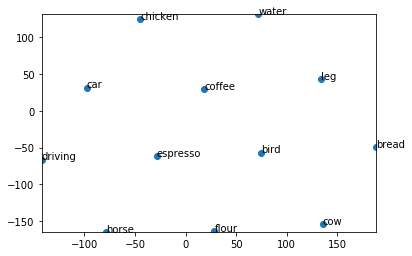

In [41]:
x_coords = Y[:, 0]
y_coords = Y[:, 1]
# display scatter plot
plt.scatter(x_coords, y_coords)

for label, x, y in zip(some_words, x_coords, y_coords):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
plt.show()

Well, this is still somewhat terrible. The words seem to be a bit better now, looks like some sentences are there, but this model has hit its limits and it doesn't appear that more training time will help at all.